In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import zipfile

zip_file_path = '/content/drive/MyDrive/DLP/A2_DATASET_Q2.zip'
extract_path = '/content/extracted_files'

try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"Successfully extracted files to {extract_path}")
except FileNotFoundError:
    print(f"Error: Zip file not found at {zip_file_path}")
except zipfile.BadZipFile:
    print(f"Error: Invalid zip file at {zip_file_path}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Successfully extracted files to /content/extracted_files


In [57]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import math
import matplotlib.pyplot as plt

**Image Compression Class**

In [58]:
class ImageCompressionDataset(Dataset):
    def __init__(self, data_pairs, target_size=(128,128)):
        self.data_pairs=data_pairs

    def __len__(self):
        return len(self.data_pairs)*len(self.data_pairs[0][1])

    def __getitem__(self, idx):
        pair_idx=idx // len(self.data_pairs[0][1])
        comp_idx=idx % len(self.data_pairs[0][1])

        original,compressed_list=self.data_pairs[pair_idx]
        compressed=compressed_list[comp_idx]
        original_tensor=torch.tensor(original.transpose(2, 0, 1), dtype=torch.float32)
        compressed_tensor=torch.tensor(compressed.transpose(2, 0, 1), dtype=torch.float32)

        return compressed_tensor,original_tensor

**Preprocessing**

In [59]:
# Resizing and normalisation
def preprocess_image(image_path,target_size=(128,128)):
    with Image.open(image_path) as img:
        img_resized=img.resize(target_size)
        img_array=np.array(img_resized)/255.0
        return img_array

In [60]:
# Data preparation for further used
def prepare_data(reference_folder,compressed_folders,base_path):
    data_pairs=[]
    for filename in os.listdir(reference_folder):
        ref_path=os.path.join(reference_folder, filename)
        compressed_images=[]

        for folder in compressed_folders:
            comp_path=os.path.join(base_path, folder, filename)
            if os.path.exists(comp_path):
                compressed_images.append(preprocess_image(comp_path))
        if compressed_images:
            original = preprocess_image(ref_path)
            data_pairs.append((original,compressed_images))
    return data_pairs

In [61]:
base_path ="/content/extracted_files"
reference_folder =os.path.join(base_path, 'refimgs')
compressed_folders=[f'qf{q}' for q in range(10,100,10)]
data_pairs = prepare_data(reference_folder, compressed_folders, base_path)

**Splitting Dataset**

In [62]:
dataset = ImageCompressionDataset(data_pairs)
#splitting dataset into train, test and validation set
train_size=int(0.8*len(dataset))
val_size=len(dataset)-train_size
train_dataset,val_dataset = random_split(dataset, [train_size,val_size])

**Data Loaders**

In [63]:
train_loader=DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader=DataLoader(val_dataset, batch_size=8)

In [64]:
class EnhancedConvAutoencoder(nn.Module):
    def __init__(self):
        super(EnhancedConvAutoencoder, self).__init__()
        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3,16,3, stride =2, padding= 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(16,32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64,3, stride= 2, padding= 1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        #decoder
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    # forward pass
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [65]:
#converting device to cuda if available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=EnhancedConvAutoencoder().to(device)
criterion=nn.MSELoss()
#optimizer adam
optimizer=optim.Adam(model.parameters(),lr= 0.001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience=5,factor=0.5)

**Early Stopping when Criteria met**

In [66]:
# On 200 Epochs
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience=patience
        self.counter=0
        self.best_loss=float('inf')
        self.early_stop=False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter =0
        else:
            self.counter+= 1
            if self.counter >= self.patience:
                self.early_stop=True


**Training fucntion**

In [67]:
#training function
def train_model(model,train_loader, val_loader,criterion , optimizer,scheduler,epochs):
    early_stopping = EarlyStopping(patience=10)
    for epoch in range(epochs):
        model.train()
        #traininga and training loss
        train_loss=0.0
        for inputs,targets in train_loader:
            inputs,targets=inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)
            loss=criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*inputs.size(0)
        #validation and validation loss
        val_loss=0.0
        model.eval()
        with torch.no_grad():
            for inputs,targets in val_loader:
                inputs,targets = inputs.to(device),targets.to(device)
                outputs=model(inputs)
                loss=criterion(outputs, targets)
                val_loss+=loss.item()*inputs.size(0)

        train_loss/=len(train_loader.dataset)
        val_loss/=len(val_loader.dataset)
        scheduler.step(val_loss)

        #printing epochs
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        #if criteria met, then stop
        if early_stopping(val_loss):
            print("Early stopping triggered")
            break

In [68]:
#training function set to 200 epochs
train_model(model,train_loader,val_loader,criterion,optimizer,scheduler,epochs=200)

Epoch 1/200, Train Loss: 0.0510, Val Loss: 0.0472
Epoch 2/200, Train Loss: 0.0256, Val Loss: 0.0202
Epoch 3/200, Train Loss: 0.0170, Val Loss: 0.0153
Epoch 4/200, Train Loss: 0.0134, Val Loss: 0.0126
Epoch 5/200, Train Loss: 0.0122, Val Loss: 0.0116
Epoch 6/200, Train Loss: 0.0124, Val Loss: 0.0124
Epoch 7/200, Train Loss: 0.0125, Val Loss: 0.0109
Epoch 8/200, Train Loss: 0.0120, Val Loss: 0.0107
Epoch 9/200, Train Loss: 0.0111, Val Loss: 0.0098
Epoch 10/200, Train Loss: 0.0108, Val Loss: 0.0100
Epoch 11/200, Train Loss: 0.0104, Val Loss: 0.0101
Epoch 12/200, Train Loss: 0.0106, Val Loss: 0.0091
Epoch 13/200, Train Loss: 0.0106, Val Loss: 0.0092
Epoch 14/200, Train Loss: 0.0100, Val Loss: 0.0095
Epoch 15/200, Train Loss: 0.0114, Val Loss: 0.0089
Epoch 16/200, Train Loss: 0.0102, Val Loss: 0.0090
Epoch 17/200, Train Loss: 0.0097, Val Loss: 0.0097
Epoch 18/200, Train Loss: 0.0093, Val Loss: 0.0080
Epoch 19/200, Train Loss: 0.0093, Val Loss: 0.0081
Epoch 20/200, Train Loss: 0.0089, Val Lo

**PSNR and SSIM**

In [69]:
# On 200 Epochs
def calculate_psnr(img1,img2):
    # Calculate PSNR between two images
    mse=np.mean((img1-img2)**2)
    #if mean squared error is zero
    if mse==0:
        return float('inf')
    return 20*math.log10(1.0/math.sqrt(mse))

In [70]:
def evaluate_model(model, data_loader):
    #Evaluate the model using PSNR and SSIM
    model.eval()
    total_psnr, total_ssim = 0.0, 0.0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets=inputs.to(device), targets.to(device)
            outputs=model(inputs).cpu().numpy()
            targets=targets.cpu().numpy()

            for i in range(len(outputs)):
                #calculating PSNR
                total_psnr+=calculate_psnr(outputs[i], targets[i])

                #calculate SSIM with proper data_range
                total_ssim+=ssim(
                    outputs[i].transpose(1,2,0), targets[i].transpose(1,2,0), win_size=7, channel_axis=-1, data_range=1.0
                )

    #computing average PSNR and SSIM
    avg_psnr=total_psnr/len(data_loader.dataset)
    avg_ssim=total_ssim/len(data_loader.dataset)

    print(f"Average PSNR: {avg_psnr:.2f}, Average SSIM: {avg_ssim:.4f}")

In [71]:
# Run the evaluation
evaluate_model(model,val_loader)

Average PSNR: 23.92, Average SSIM: 0.7375


**On 200 Epochs**

In [72]:
#function to visualise original and reconstructed image
def show_images(original,reconstructed):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original.transpose(1, 2, 0))
    axs[0].set_title("Original")
    axs[0].axis('off')
    axs[1].imshow(reconstructed.transpose(1, 2, 0))
    axs[1].set_title("Reconstructed")
    axs[1].axis('off')
    plt.show()

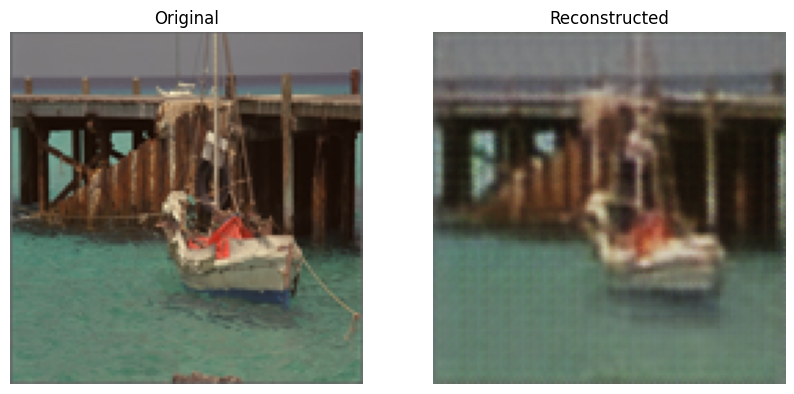

In [73]:
#image from a batch from validation loader
inputs, targets = next(iter(val_loader))
outputs = model(inputs.to(device)).cpu().detach().numpy()
show_images(targets[0].numpy(), outputs[0])

**On 1000 Epochs**

In [74]:
#training function set to 1000 epochs
train_model(model,train_loader,val_loader,criterion,optimizer,scheduler,epochs=1000)

Epoch 1/1000, Train Loss: 0.0054, Val Loss: 0.0045
Epoch 2/1000, Train Loss: 0.0056, Val Loss: 0.0045
Epoch 3/1000, Train Loss: 0.0057, Val Loss: 0.0045
Epoch 4/1000, Train Loss: 0.0054, Val Loss: 0.0045
Epoch 5/1000, Train Loss: 0.0054, Val Loss: 0.0045
Epoch 6/1000, Train Loss: 0.0055, Val Loss: 0.0045
Epoch 7/1000, Train Loss: 0.0056, Val Loss: 0.0045
Epoch 8/1000, Train Loss: 0.0055, Val Loss: 0.0045
Epoch 9/1000, Train Loss: 0.0056, Val Loss: 0.0045
Epoch 10/1000, Train Loss: 0.0052, Val Loss: 0.0045
Epoch 11/1000, Train Loss: 0.0058, Val Loss: 0.0045
Epoch 12/1000, Train Loss: 0.0057, Val Loss: 0.0045
Epoch 13/1000, Train Loss: 0.0053, Val Loss: 0.0045
Epoch 14/1000, Train Loss: 0.0056, Val Loss: 0.0045
Epoch 15/1000, Train Loss: 0.0056, Val Loss: 0.0045
Epoch 16/1000, Train Loss: 0.0053, Val Loss: 0.0045
Epoch 17/1000, Train Loss: 0.0054, Val Loss: 0.0045
Epoch 18/1000, Train Loss: 0.0054, Val Loss: 0.0045
Epoch 19/1000, Train Loss: 0.0057, Val Loss: 0.0045
Epoch 20/1000, Train 

In [75]:
evaluate_model(model,val_loader)

Average PSNR: 23.91, Average SSIM: 0.7374


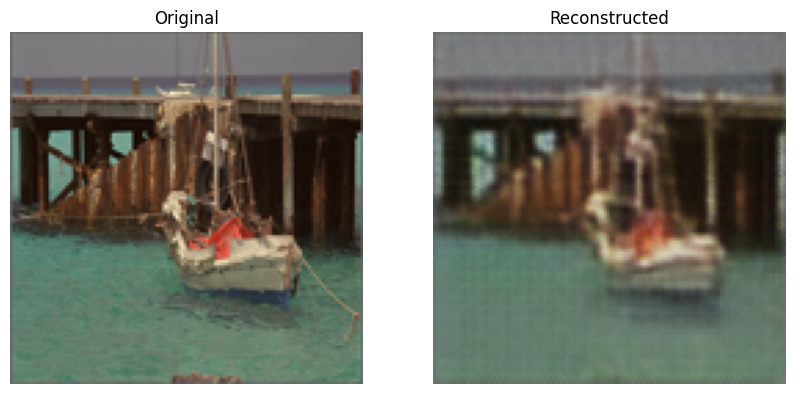

In [76]:
#showing original and reconstructed images on 1000 epochs
inputs,targets=next(iter(val_loader))
outputs = model(inputs.to(device)).cpu().detach().numpy()
show_images(targets[0].numpy(),outputs[0])

**Analysis:**

Trade-offs between Model Complexity, Training Time, and Reconstruction Accuracy
Training the model for 100 epochs showed significant improvements, with validation loss steadily decreasing and PSNR reaching around 24.0 dB, while SSIM settled at approximately 0.76. However, when extended to 1000 epochs, the improvements became marginal after 300-400 epochs. The PSNR increased slightly to 24.2-24.5 dB, with SSIM rising to about 0.77, indicating diminishing returns.

This highlights the trade-off between training time and accuracy—longer training brings minimal gains while increasing computational costs. Moreover, the fluctuations in validation loss during extended training suggested risks of overfitting. Efficient practices like early stopping or learning rate scheduling could prevent unnecessary training beyond the point of meaningful improvement.

In practice, running the model for 100-300 epochs appears sufficient, striking a balance between accuracy and time. Improvements might be better achieved through architectural enhancements rather than prolonged training, making the model more practical and resource-efficient.